In [1]:
# required modules (skip if already installed)
if False:
    !pip install pyroaring
    !pip install pyfim 
    # if previous does not work, try: !conda install -c conda-forge pyfim
    !pip install lightgbm
    !pip install fairlearn
    !pip install pydotplus

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# global imports
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# local imports
# sys.path.append('../src/') # local path
# import dd

# general settings  
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=11)
plt.rc('legend', fontsize=11)
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('axes', edgecolor='k')
plt.rc('xtick.major', width=2)
plt.rc('xtick.major', size=6)
plt.rc('ytick.major', width=2)
plt.rc('ytick.major', size=6)
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

In [3]:
# local imports
# set working directory - note: all code runs from the src folder
wrk_dir = os.getcwd()

# data path
data_path = wrk_dir + '\\' + 'data' + '\\'
# results path
resu_path = wrk_dir + '\\' + 'results\\counterfactuals' + '\\'

import src.dd as dd
import src.cf_situation_testing

In [14]:
df = pd.read_csv(data_path + 'Karimi2020_v2.csv', sep='|', )
del df['u1']
del df['u2']
# for 'convinience' make 'Gender' var explicit
df['Gender'] = df['Gender'].map({0: 'Male', 1: 'Female'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4993 entries, 0 to 4992
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   LoanApproval    4993 non-null   float64
 1   AnnualSalary    4993 non-null   int64  
 2   AccountBalance  4993 non-null   float64
 3   Gender          4993 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 156.2+ KB


In [15]:
# some missing values present
df.isna().sum()

LoanApproval      0
AnnualSalary      0
AccountBalance    0
Gender            0
dtype: int64

In [16]:
df.head(5)

,LoanApproval,AnnualSalary,AccountBalance,Gender
0,-1.0,35000,7947.678090,Female
1,1.0,120000,36940.097383,Male
2,-1.0,90000,23564.129008,Male
3,-1.0,80000,27596.570524,Male
4,1.0,201000,59008.567839,Female


In [17]:
# nominal-ordinal-continuous partition of predictive attributes (required for distance functions)
nominal_atts = ['Gender']
ordinal_atts = []
continuous_atts = ['AnnualSalary', 'AccountBalance']
# encoding of ordinal attributes as integers plus (optional) encoding of nominal/target attributes
decode = {
    'Gender': {0: 'Male', 1: 'Female'},
    'LoanApproval': {0: -1.0, 1: 1.0}
}
# predictive attributes (for models)
target = 'LoanApproval'
pred_atts = nominal_atts + ordinal_atts + continuous_atts
print(pred_atts)
pred_all = pred_atts + [target]
print(pred_all)

['Gender', 'AnnualSalary', 'AccountBalance']
['Gender', 'AnnualSalary', 'AccountBalance', 'LoanApproval']


In [18]:
# encode nominal, ordinal, and target attribute
df_code = dd.Encode(nominal_atts + ordinal_atts + [target], decode)
df = df_code.fit_transform(df)
# set ordinal type as int (instead of category)
df[ordinal_atts] = df[ordinal_atts].astype(int)
# workclass, occupation and native-country are float because there are missing values
df.head()

,Gender,LoanApproval,AccountBalance,AnnualSalary
0,1,0,7947.678090,35000
1,0,1,36940.097383,120000
2,0,0,23564.129008,90000
3,0,0,27596.570524,80000
4,1,1,59008.567839,201000


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4993 entries, 0 to 4992
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Gender          4993 non-null   category
 1   LoanApproval    4993 non-null   category
 2   AccountBalance  4993 non-null   float64 
 3   AnnualSalary    4993 non-null   int64   
dtypes: category(2), float64(1), int64(1)
memory usage: 88.1 KB


In [20]:
# dictionary of encodings for each discrete column
df_code.decode

{'Gender': {0: 'Male', 1: 'Female'}, 'LoanApproval': {0: -1.0, 1: 1.0}}

In [21]:
# split train test
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.33, random_state=42)

### Individual discrimination settings

In [22]:
# object for indvidual discrimination analysis
dist = dd.ID(df, nominal_atts, continuous_atts, ordinal_atts)
# protected attribute
pro_att = 'Gender'
unpro_val = df_code.encode['Gender']['Male']
# number of neighbors
k = 16

In [23]:
# example of distance between two instances
print(df.loc[0], '\n', df.loc[1])
dist.kdd2011dist(df.loc[0], df.loc[1])

Gender                1.00000
LoanApproval          0.00000
AccountBalance     7947.67809
AnnualSalary      35000.00000
Name: 0, dtype: float64 
 Gender                 0.000000
LoanApproval           1.000000
AccountBalance     36940.097383
AnnualSalary      120000.000000
Name: 1, dtype: float64


2.1241029387631696

In [24]:
# example of distance between an instance and each instance in a dataframe
print(df.loc[0], '\n', df.loc[1:5])
dist.kdd2011dist(df.loc[0], df.loc[1:5])

Gender                1.00000
LoanApproval          0.00000
AccountBalance     7947.67809
AnnualSalary      35000.00000
Name: 0, dtype: float64 
   Gender LoanApproval  AccountBalance  AnnualSalary
1      0            1    36940.097383        120000
2      0            0    23564.129008         90000
3      0            0    27596.570524         80000
4      1            1    59008.567839        201000
5      1            1    26000.811689        102000


1    2.124103
2    1.390802
3    1.419914
4    3.318162
5    1.256922
dtype: float64

In [25]:
%%time
unpro_train = df_train[pro_att]==unpro_val
pro_train = df_train[pro_att]!=unpro_val
# sets risk difference for target based on top-k neighbor instances
df_train['t'] = dist.topkdiff(df_train, # dataset
                              unpro_train, # unprotected
                              pro_train, # protected (could be a list)
                              target, # decision
                              dist.kdd2011dist, # distance
                              k) # k

Wall time: 7.81 s


<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [26]:
df_train

,Gender,LoanApproval,AccountBalance,AnnualSalary,t
3738,0,1,31055.202890,110000,0.0
761,0,1,36856.581234,130000,0.0
1894,1,0,15620.381725,50500,0.0
1860,0,1,37347.514240,120000,0.0
3022,0,0,23422.795513,70000,0.0
...,...,...,...,...,...
4426,1,1,34069.489483,113500,0.0
466,1,1,31302.021155,113500,0.0
3092,1,1,27305.573635,95000,0.0
3772,0,1,41796.745217,130000,0.0


In [27]:
# training model and make predictions - lightgbm able to deal with categorial attributes (no need for onehot encodings)
import lightgbm as lgb

clf = lgb.LGBMClassifier(random_state=42)
clf.fit(df_train[pred_atts], df_train[target].astype(int))
# add predicted class and score in the df_test
df_test['pred_b'] = clf.predict(df_test[pred_atts])
df_test['score_b'] = clf.predict_proba(df_test[pred_atts])[:,1]
# set decode of pred_b
df_code.decode['pred_b'] = df_code.decode[target]
df_test.head()

<ipython-input-27-5f4c0a13566c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred_b'] = clf.predict(df_test[pred_atts])
<ipython-input-27-5f4c0a13566c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['score_b'] = clf.predict_proba(df_test[pred_atts])[:,1]


,Gender,LoanApproval,AccountBalance,AnnualSalary,pred_b,score_b
3169,0,1,36477.962884,120000,1,0.999979
3100,0,1,37318.348274,130000,1,0.999979
624,1,1,38988.445711,133500,1,0.999979
4037,0,1,44535.428111,140000,1,0.999979
969,0,1,43746.293116,150000,1,0.999979


In [28]:
%%time
unpro_test = df_test[pro_att]==unpro_val
pro_test = df_test[pro_att]!=unpro_val
# sets risk difference for target based on top-k neighbor instances
df_test['t_b'] = dist.topkdiff(df_test, # dataset
                              unpro_test, # unprotected
                              pro_test, # protected (could be a list)
                              'pred_b', # decision
                              dist.kdd2011dist, # distance
                              k) # k

Wall time: 3.82 s


<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


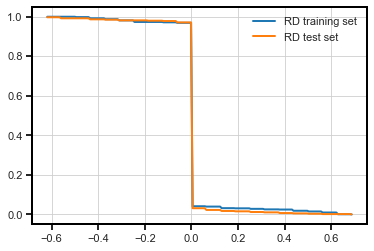

In [29]:
# CCDF of risk difference in both training and test
count, bins_count = np.histogram(df_train[pro_train]['t'], bins=200)
ccdf = 1 - np.cumsum(count)/sum(count)
plt.plot(bins_count[1:], ccdf, label='RD training set')
count, bins_count = np.histogram(df_test[pro_test]['t_b'], bins=200)
ccdf = 1 - np.cumsum(count)/sum(count)
plt.plot(bins_count[1:], ccdf, label='RD test set')
plt.legend()
plt.show()

### re-run to compare against cfST:

In [31]:
# let's compare to the cf_st results:

# 1) same k=10
# object for indvidual discrimination analysis
dist = dd.ID(df, nominal_atts, continuous_atts, ordinal_atts)
# protected attribute
pro_att = 'Gender'
unpro_val = df_code.encode['Gender']['Male']
# number of neighbors
k = 10

In [34]:
df2 = df.copy()
df2.head(5)

,Gender,LoanApproval,AccountBalance,AnnualSalary
0,1,0,7947.678090,35000
1,0,1,36940.097383,120000
2,0,0,23564.129008,90000
3,0,0,27596.570524,80000
4,1,1,59008.567839,201000


In [36]:
# 2) use the full dataset
unpro_train = df2[pro_att] == unpro_val
pro_train   = df2[pro_att] != unpro_val
# sets risk difference for target based on top-k neighbor instances
df2['t'] = dist.topkdiff(df2,    # dataset
                         unpro_train, # unprotected
                         pro_train,   # protected (could be a list)
                         target,      # decision
                         dist.kdd2011dist, # distance
                         k) # k

In [37]:
df2.head(5)

,Gender,LoanApproval,AccountBalance,AnnualSalary,t
0,1,0,7947.678090,35000,0.0
1,0,1,36940.097383,120000,0.0
2,0,0,23564.129008,90000,0.0
3,0,0,27596.570524,80000,0.0
4,1,1,59008.567839,201000,0.0


In [40]:
# set maximum RD
t = 0.15

In [42]:
print(df2[df2['t'] >= t].shape)
df2[df2['t'] >= t]

(42, 5)


,Gender,LoanApproval,AccountBalance,AnnualSalary,t
147,1,1,27819.899563,86500,0.6
264,1,1,28102.592939,85500,0.3
502,1,0,24589.519535,96500,0.6
798,1,0,24896.115872,96500,0.8
1044,1,0,24195.883319,98000,0.5
1306,1,0,24575.033555,98000,0.6
1313,1,1,25939.058333,96500,0.3
1364,1,0,24765.039079,100500,0.5
1536,1,0,25402.323867,96500,0.7
1573,1,0,27044.084618,85000,0.2


Notes for Salvatore:
- why do I get ppl with positive loan approval?
- no normalization for the vars?
- is the distance function Manhattan still? still Wald CIs?

While we find 42 cases here (to discuss), cf_ST gets 443. Ofc, we need to use the same theshold, etc. (to discuss too). 

### Correct training data and re-train

In [30]:
# todo ...